# Predicting bike sharing demand
## Using AutoGluon - AutoML

<hr/>

### Submitted by Abhijith Ganesh


The bike sharing [Kaggle](https://www.kaggle.com/bike-sharing-demand) dataset is a popular dataset that is used for machine learning enthusiasts and practioners to test out fits. For this challenge, I've used the AutoGluon library to predict the bike sharing demand.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime

## Adding all constants and file directories
<hr/>

_Please change this according to your environment_

In [2]:
dataset = "./dataset"
test_set = dataset+"/test.csv"
train_set = dataset+"/train.csv"

## Using Kaggle CLI to download the dataset

In [3]:
%%capture
%pip install --user kaggle
# !kaggle competitions download -c bike-sharing-demand -p $dataset

## Data checking and validation with Pandas

-> Checks and tests with Pandas

In [4]:
test_dataset = pd.read_csv(test_set)
train_dataset = pd.read_csv(train_set)

In [5]:
train_dataset.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


In [6]:
train_dataset.shape

(10886, 12)

In [7]:
train_dataset.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


## Feature engineering datetime

The dataset contains a string `datetime`, it would be ideal if we have the following for the dataset:
- Date split into Month, Day and Year
- Time of the day

In [8]:
train_dataset["datetime"] = pd.to_datetime(train_dataset["datetime"])
train_dataset["year"] = train_dataset["datetime"].dt.year
train_dataset["month"] = train_dataset["datetime"].dt.month
train_dataset["day"] = train_dataset["datetime"].dt.day
train_dataset["time"] = train_dataset["datetime"].dt.hour


test_dataset["datetime"] = pd.to_datetime(test_dataset["datetime"])
test_dataset["year"] = test_dataset["datetime"].dt.year
test_dataset["month"] = test_dataset["datetime"].dt.month
test_dataset["day"] = test_dataset["datetime"].dt.day
test_dataset["time"] = test_dataset["datetime"].dt.hour

In [9]:
test_dataset.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,month,day,time
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027,2011,1,20,0
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000,2011,1,20,1
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000,2011,1,20,2
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014,2011,1,20,3
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014,2011,1,20,4


## Plotting correlation indices
<hr/>


It is usally practice to plot all correlation values to implement [CBFS](https://www.cs.waikato.ac.nz/~mhall/thesis.pdf) because training a model like regression on this will be useful.

In [10]:
train_dataset["count_two"] = train_dataset["registered"]+train_dataset["casual"]
train_dataset.corr()

/tmp/ipykernel_6024/1806583196.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  train_dataset.corr()


,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,time,count_two
season,1.000000,0.029368,-0.008126,0.008879,0.258689,0.264744,0.190610,-0.147121,0.096758,0.164011,0.163439,-0.004797,0.971524,0.001729,-0.006546,0.163439
holiday,0.029368,1.000000,-0.250491,-0.007074,0.000295,-0.005215,0.001929,0.008409,0.043799,-0.020956,-0.005393,0.012021,0.001731,-0.015877,-0.000354,-0.005393
workingday,-0.008126,-0.250491,1.000000,0.033772,0.029966,0.024660,-0.010880,0.013373,-0.319111,0.119460,0.011594,-0.002482,-0.003394,0.009829,0.002780,0.011594
weather,0.008879,-0.007074,0.033772,1.000000,-0.055035,-0.055376,0.406244,0.007261,-0.135918,-0.109340,-0.128655,-0.012548,0.012144,-0.007890,-0.022740,-0.128655
temp,0.258689,0.000295,0.029966,-0.055035,1.000000,0.984948,-0.064949,-0.017852,0.467097,0.318571,0.394454,0.061226,0.257589,0.015551,0.145430,0.394454
atemp,0.264744,-0.005215,0.024660,-0.055376,0.984948,1.000000,-0.043536,-0.057473,0.462067,0.314635,0.389784,0.058540,0.264173,0.011866,0.140343,0.389784
humidity,0.190610,0.001929,-0.010880,0.406244,-0.064949,-0.043536,1.000000,-0.318607,-0.348187,-0.265458,-0.317371,-0.078606,0.204537,-0.011335,-0.278011,-0.317371
windspeed,-0.147121,0.008409,0.013373,0.007261,-0.017852,-0.057473,-0.318607,1.000000,0.092276,0.091052,0.101369,-0.015221,-0.150192,0.036157,0.146631,0.101369
casual,0.096758,0.043799,-0.319111,-0.135918,0.467097,0.462067,-0.348187,0.092276,1.000000,0.497250,0.690414,0.145241,0.092722,0.014109,0.302045,0.690414
registered,0.164011,-0.020956,0.119460,-0.109340,0.318571,0.314635,-0.265458,0.091052,0.497250,1.000000,0.970948,0.264265,0.169451,0.019111,0.380540,0.970948


In [11]:
train_dataset.dtypes

datetime      datetime64[ns]
season                 int64
holiday                int64
workingday             int64
weather                int64
temp                 float64
atemp                float64
humidity               int64
windspeed            float64
casual                 int64
registered             int64
count                  int64
year                   int64
month                  int64
day                    int64
time                   int64
count_two              int64
dtype: object

## Decision One

I am going to drop registered and casual as they sum up to count

In [12]:
train_dataset = train_dataset.drop(["count_two", "casual", "registered"], axis=1)
train_dataset

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year,month,day,time
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,16,2011,1,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,40,2011,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,32,2011,1,1,2
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,13,2011,1,1,3
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,1,2011,1,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,336,2012,12,19,19
10882,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,241,2012,12,19,20
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,168,2012,12,19,21
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,129,2012,12,19,22


In [13]:
test_dataset.dtypes

datetime      datetime64[ns]
season                 int64
holiday                int64
workingday             int64
weather                int64
temp                 float64
atemp                float64
humidity               int64
windspeed            float64
year                   int64
month                  int64
day                    int64
time                   int64
dtype: object

In [14]:
len(train_dataset.columns)-1 == len(test_dataset.columns)

True

It can be observed `count` is the only missing field, and hence the dataset is good to go

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0941bbe910>,
      dtype=object)

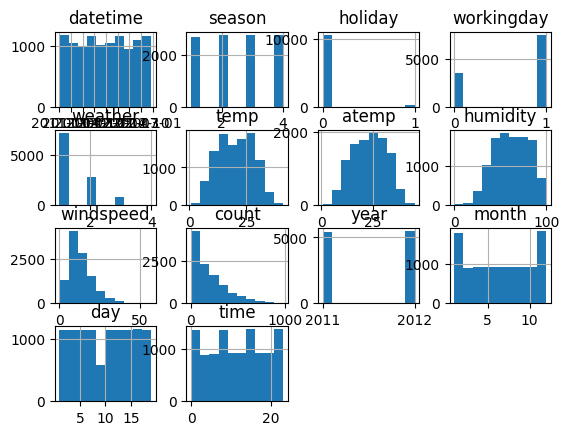

In [15]:
%matplotlib inline
train_dataset.hist()

## Using AutoGluon

<hr/>


In [16]:
%%capture
%pip install autogluon

In [17]:
from autogluon.tabular import TabularDataset, TabularPredictor

## Addition of HyperParameters
<hr/>

I've already run this code multiple times, so I found out the hyper parameters as shown in the line below. Now, to get the code of hyper parameters, run the lines below first.

### Used hyper parameters

- GPUs = 0
- weight_evaluation

In [18]:
config = {
    "gpus":0,
}
hyperparams = {
    "GBM":{
        "weight_evaluation":True,
    },
}
time_limit = 60*30*30
hyp = 'auto'

In [19]:
predictor = TabularPredictor(label='count').fit(
     train_dataset,
     hyperparameters = hyperparams,
     num_gpus=config["gpus"]
)

No path specified. Models will be saved in: "AutogluonModels/ag-20230525_161518/"
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20230525_161518/"
AutoGluon Version:  0.7.0
Python Version:     3.8.5
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #42~20.04.1-Ubuntu SMP Wed Mar 1 19:17:41 UTC 2023
Train Data Rows:    10886
Train Data Columns: 13
Label Column: count
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == int and many unique label-values observed).
	Label info (max, min, mean, stddev): (977, 1, 191.57413, 181.14445)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    13185.52

[LightGBM] [Warning] Unknown parameter: weight_evaluation


	-35.3221	 = Validation score   (-root_mean_squared_error)
	3.37s	 = Training   runtime
	0.03s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ...
	-35.3221	 = Validation score   (-root_mean_squared_error)
	0.01s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 5.71s ... Best model: "WeightedEnsemble_L2"
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("AutogluonModels/ag-20230525_161518/")


## Predictor Leaderboard
I'll be referencing the metrics of the various models and compare to choose the hyperparameters

In [20]:
predictor.leaderboard()

                 model  score_val  pred_time_val  fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0             LightGBM -35.322139       0.027424  3.365703                0.027424           3.365703            1       True          1
1  WeightedEnsemble_L2 -35.322139       0.028101  3.372842                0.000677           0.007139            2       True          2


,model,score_val,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,LightGBM,-35.322139,0.027424,3.365703,0.027424,3.365703,1,True,1
1,WeightedEnsemble_L2,-35.322139,0.028101,3.372842,0.000677,0.007139,2,True,2


In [21]:
predictor.get_model_best()

'WeightedEnsemble_L2'

In [22]:
test_dataset.dtypes

datetime      datetime64[ns]
season                 int64
holiday                int64
workingday             int64
weather                int64
temp                 float64
atemp                float64
humidity               int64
windspeed            float64
year                   int64
month                  int64
day                    int64
time                   int64
dtype: object

In [23]:
predictor.predict(test_dataset)

0        14.547768
1         2.654929
2        -0.606265
3         3.687485
4         3.687485
           ...    
6488    366.880280
6489    246.444092
6490    160.011536
6491    104.248062
6492     49.088245
Name: count, Length: 6493, dtype: float32

## Post Training Sunnary

<hr/>

We'll be recording the details of the summary of the predictors and the best model that should be used

### Analysis
The Weighted Ensemble based on L2 normalization worked the best

In [24]:
predictor.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                 model  score_val  pred_time_val  fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0             LightGBM -35.322139       0.027424  3.365703                0.027424           3.365703            1       True          1
1  WeightedEnsemble_L2 -35.322139       0.028101  3.372842                0.000677           0.007139            2       True          2
Number of models trained: 2
Types of models trained:
{'LGBModel', 'WeightedEnsembleModel'}
Bagging used: False 
Multi-layer stack-ensembling used: False 
Feature Metadata (Processed):
(raw dtype, special dtypes):
('float', [])                : 3 | ['temp', 'atemp', 'windspeed']
('int', [])                  : 6 | ['season', 'weather', 'humidity', 'month', 'day', ...]
('int', ['bool'])            : 3 | ['holiday', 'workingday', 'year']
('int', ['datetime_as_int']) : 5 | ['datetime', 'datetime.year', 'datetime.month', 'datet

{'model_types': {'LightGBM': 'LGBModel',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel'},
 'model_performance': {'LightGBM': -35.32213949184312,
  'WeightedEnsemble_L2': -35.32213949184312},
 'model_best': 'WeightedEnsemble_L2',
 'model_paths': {'LightGBM': 'AutogluonModels/ag-20230525_161518/models/LightGBM/',
  'WeightedEnsemble_L2': 'AutogluonModels/ag-20230525_161518/models/WeightedEnsemble_L2/'},
 'model_fit_times': {'LightGBM': 3.3657026290893555,
  'WeightedEnsemble_L2': 0.007138967514038086},
 'model_pred_times': {'LightGBM': 0.027424335479736328,
  'WeightedEnsemble_L2': 0.0006771087646484375},
 'num_bag_folds': 0,
 'max_stack_level': 2,
 'model_hyperparams': {'LightGBM': {'learning_rate': 0.05,
   'weight_evaluation': True},
  'WeightedEnsemble_L2': {'use_orig_features': False,
   'max_base_models': 25,
   'max_base_models_per_type': 5,
   'save_bag_folds': True}},
 'leaderboard':                  model  score_val  pred_time_val  fit_time  \
 0             LightGBM -35.3221

## Closing statements
These results were submitted to Kaggle!